<a href="https://colab.research.google.com/github/finardi/tutos/blob/master/Census_com_Calibra%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Tue Dec 22 23:12:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Basics
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch 
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import quantile_transform

# Scipy
from scipy import stats

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
manual_seed = 2357

def deterministic(rep=True):
    if rep:
        np.random.seed(manual_seed)
        torch.manual_seed(manual_seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(manual_seed)
            torch.cuda.manual_seed_all(manual_seed)
        torch.backends.cudnn.enabled = False 
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        print(f'Deterministic experiment, seed: {manual_seed}')
    else:
        print('Random experiment')

deterministic()

Deterministic experiment, seed: 2357


In [ ]:
try:
    df = pd.read_csv('/content/CensusData.csv');
except:
    !unzip '/content/drive/MyDrive/Colab Notebooks/Tabular/36093_54253_bundle_archive.zip'
    df = pd.read_csv('/content/CensusData.csv');

Archive:  /content/drive/MyDrive/Colab Notebooks/Tabular/36093_54253_bundle_archive.zip
  inflating: CensusData.csv          


In [ ]:
df.head()

,Age,workclass,fnlwgt,education,education-num,Marital-status,Occupation,Relationship,Race,Sex,capital-gain,capital-loss,hours-per-week,native-country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Troca do Label para numérico

In [ ]:
# Verificar a contagem antes
df.Income.value_counts()

 <=50K    24720
 >50K      7841
Name: Income, dtype: int64

In [ ]:
# Verificar a contagem depois
df['Income'] = np.where(df['Income'] == ' <=50K', 0,1)
df.Income.value_counts()

0    24720
1     7841
Name: Income, dtype: int64

### Fazer split entre train e test

In [ ]:
df_train, df_test, y_train, y_test = train_test_split(df.iloc[:, :-1],df.Income, test_size=0.3, stratify=df.Income)

# volta para dataframe
df_train = pd.DataFrame(df_train)
df_test = pd.DataFrame(df_test)
df_train.shape, y_train.shape, df_test.shape, y_test.shape

((22792, 14), (22792,), (9769, 14), (9769,))

In [ ]:
df_train.head()

,Age,workclass,fnlwgt,education,education-num,Marital-status,Occupation,Relationship,Race,Sex,capital-gain,capital-loss,hours-per-week,native-country
27093,18,Private,334676,HS-grad,9,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,25,United-States
29276,35,Private,397307,Masters,14,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,55,United-States
18695,45,Private,197240,12th,8,Married-civ-spouse,Sales,Husband,White,Male,7688,0,40,United-States
30282,34,Private,28053,Bachelors,13,Married-spouse-absent,Adm-clerical,Not-in-family,White,Female,0,0,25,United-States
14318,27,Private,74883,Bachelors,13,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Female,0,0,40,Philippines


### Tratar colunas categóricas

In [ ]:
df.dtypes

Age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
Marital-status    object
Occupation        object
Relationship      object
Race              object
Sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
Income             int64
dtype: object

In [ ]:
columns   = df.columns.to_list() # todas as colunas
col_types = df.dtypes.to_list()  # todos os tipos de colunas
col_types

[dtype('int64'),
 dtype('O'),
 dtype('int64'),
 dtype('O'),
 dtype('int64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('O'),
 dtype('int64')]

In [ ]:
num_cols, cat_cols = [], []
for e in zip(columns, col_types):
    if e[1] == 'object':
        cat_cols.append(e[0])
    else:
        num_cols.append(e[0])

# excluit o target Income da num_cols
num_cols.pop(-1)

print(cat_cols, '\n')
print(num_cols)

['workclass', 'education', 'Marital-status', 'Occupation', 'Relationship', 'Race', 'Sex', 'native-country'] 

['Age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


In [500]:
def map_categorical_train(df_train, cat_cols):
    df = df_train.copy()
    cat_dims, list_of_dicts = [], []
    
    for col in cat_cols:
        j = 1
        my_dict = {}
        my_dict.update({' ?':0})
        my_dict.update({'UNK':1})

        for e in df[col].value_counts().index.to_list():
            if e not in my_dict.keys():
                j +=1
                my_dict.update({e:j})
        list_of_dicts.append(my_dict)
        cat_dims.append(len(my_dict))

        df[col] = df[col].apply(lambda x: my_dict[x] if x in 
                                my_dict.keys() else my_dict['UNK'])
        
        emb_szs = [(c, min(100, (2*c)//2)) for c in cat_dims]
        cat_emb_dims = [e[0] for e in emb_szs]

    return df, list_of_dicts, emb_szs, cat_dims

#----------------------------------------------------------------------------------
def map_categorical_test(df_test, list_of_dicts):
    df = df_test.copy()
    for i, col in enumerate(cat_cols):
        df[col] = df[col].apply(lambda x: list_of_dicts[i][x] if x in 
                                list_of_dicts[i].keys() else list_of_dicts[i]['UNK'])
    return df

In [501]:
df_train_, list_of_dicts, emb_szs, cat_dims = map_categorical_train(df_train, cat_cols)   
df_test_ = map_categorical_test(df_test, list_of_dicts)   
print(df_train_.shape, df_test_.shape)

(22792, 14) (9769, 14)


In [502]:
# Conferindo
df_train_.head()

,Age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass,education,Marital-status,Occupation,Relationship,Race,Sex,native-country
27093,0.020020,0.907503,0.148148,0.00000,0.0,0.111111,2,2,3,11,4,2,2,2
29276,0.447447,0.959688,0.942442,0.00000,0.0,0.904404,2,5,3,4,3,2,3,2
18695,0.694194,0.606847,0.123123,0.97047,0.0,0.472472,2,13,2,6,2,2,2,2
30282,0.420420,0.012079,0.834334,0.00000,0.0,0.111111,2,4,7,5,3,2,3,2
14318,0.233734,0.113113,0.834334,0.00000,0.0,0.472472,2,4,3,13,3,4,3,5


### Tratamento colunas numéricas

In [503]:
def normalize(df, num_cols, cat_cols, norm='minmax'):
    data = df.copy()
    df_num = df[num_cols]
    
    if norm == 'minmax':
        m_m_s = MinMaxScaler()
        mim_max_scal = m_m_s.fit(df_num.values)
        mim_max_scal = m_m_s.transform(df_num.values)
        df_norm = pd.DataFrame(data=mim_max_scal, 
                        columns=df_num.columns, 
                        index=df_num.index)

    if norm == 'quantile':
        quantile = quantile_transform(df_num.values, 
                        random_state=2357, 
                        copy=True, 
                        output_distribution='uniform')
        df_norm  = pd.DataFrame(data=quantile, 
                        columns=df_num.columns, 
                        index=df_num.index)

    df= pd.concat((
        df_norm, 
        df[cat_cols]), 
        axis=1)
    return df

In [504]:
# df_train[num_cols]
num_cols

['Age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [505]:
df_train = normalize(df_train_, num_cols, cat_cols, norm='quantile')
df_test  = normalize(df_test_, num_cols, cat_cols, norm='quantile') 

# Conferindo

In [506]:
df_train

,Age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass,education,Marital-status,Occupation,Relationship,Race,Sex,native-country
27093,0.020020,0.907503,0.293293,0.00000,0.0,0.111111,2,2,3,11,4,2,2,2
29276,0.447447,0.959688,0.942442,0.00000,0.0,0.904404,2,5,3,4,3,2,3,2
18695,0.694194,0.606847,0.123123,0.97047,0.0,0.472472,2,13,2,6,2,2,2,2
30282,0.420420,0.012080,0.834334,0.00000,0.0,0.111111,2,4,7,5,3,2,3,2
14318,0.233734,0.113113,0.834334,0.00000,0.0,0.472472,2,4,3,13,3,4,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22287,0.061562,0.935532,0.566567,0.00000,0.0,0.143644,2,3,3,4,4,2,3,2
31114,0.259760,0.595756,0.293293,0.00000,0.0,0.472472,2,2,2,8,2,2,2,2
24108,0.600601,0.919574,0.834334,0.00000,0.0,0.843844,2,4,4,4,3,2,2,2
17802,0.649650,0.908950,0.293293,0.00000,0.0,0.472472,2,2,5,10,3,2,2,2


## Criar classe do dataset

In [507]:
class CensusDataset(Dataset):
    def __init__(self, df, num_cols, cat_cols, target):
        super(CensusDataset, self).__init__()

        self.x_cont = df[num_cols].values.copy().astype(np.float32)
        self.x_cat  = df[cat_cols].values.copy().astype(np.int64)
        
        self.y      = target.values.reshape(-1).copy().astype(np.int64)
        
    def __len__(self):
        return self.x_cat.shape[0]
    
    def __getitem__(self, index):
        x_cont = self.x_cont[index]
        x_cat  = self.x_cat[index]
        
        y      = self.y[index]
        
        return x_cont, x_cat, y

# testando
ds = CensusDataset(df_train, 
                     num_cols, 
                     cat_cols, 
                     y_train)
x_cont, x_cat, y = ds[0]
x_cont.shape, x_cat.shape, y

((6,), (8,), 0)

# Dataloaders

In [508]:
BATCH_SZ = 128

# datasets
ds_train = CensusDataset(df_train, 
                     num_cols, 
                     cat_cols, 
                     y_train)

ds_debug = CensusDataset(df_train[:BATCH_SZ], 
                     num_cols, 
                     cat_cols, 
                     y_train[:BATCH_SZ])


ds_test  = CensusDataset(df_test, 
                     num_cols, 
                     cat_cols, 
                     y_test)

# dataloaders
dataloaders = {
     'train': DataLoader(ds_train,
                         batch_size=BATCH_SZ,
                         shuffle = True, 
                         num_workers=4,
                         pin_memory=True),
     'test' : DataLoader(ds_test,
                         batch_size=BATCH_SZ,
                         shuffle=False,
                         num_workers=4,
                         pin_memory=True),
     'debug': DataLoader(ds_debug,
                         batch_size=BATCH_SZ,
                         shuffle=False,
                         num_workers=4,
                         pin_memory=True)
     }

# sanity check
dl_sizes = {x: len(dataloaders[x]) for x in dataloaders.keys()}
dl_sizes 

{'debug': 1, 'test': 77, 'train': 179}

In [509]:
x_cont, x_cat, y= next(iter(dataloaders['train']))
torch.mean(y.type(torch.float))

tensor(0.2656)

# Modelo

In [544]:
class CatModel(nn.Module):
    def __init__(self, embedding_sizes=emb_szs, n_cont=len(num_cols), out=2):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) 
                    for categories,size in embedding_sizes])
        
        n_emb_sum = sum(e.embedding_dim for e in self.embeddings) 
        d_model   = n_emb_sum + n_cont

        self.actv = nn.SELU()
        
        self.bnc  = nn.BatchNorm1d(n_cont)
        
        self.fc0  = nn.Linear(d_model, 2 * n_emb_sum)
        self.drop = nn.Dropout()

        self.fc1  = nn.Linear(2 * n_emb_sum, n_emb_sum)
        self.bn1  = nn.BatchNorm1d(n_emb_sum)

        self.fc2  = nn.Linear(n_emb_sum, out)

    def forward(self, x_cont, x_cat):
        xcat = [e(x_cat[:,i]) for i, e in enumerate(self.embeddings)]
        xcat = torch.cat(xcat, dim=1)
        xcat = self.drop(xcat) 
        
        xcont = self.bnc(x_cont)
        o = torch.cat((xcont, xcat), dim=1)
        
        o = self.fc0(o)
        o = self.actv(o)

        o = self.fc1(o)
        o = self.bn1(o)
        o = self.actv(o)
        o = self.drop(o)


        return self.fc2(o)
#--------------------------------------------------------------------------------
model = CatModel(
    embedding_sizes=emb_szs, 
    n_cont=len(num_cols), 
    )
with torch.no_grad():
    print(model(x_cont, x_cat).shape)   

torch.Size([128, 2])


In [545]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('\n','#' * 45,f'\n # The model has {count_parameters(model):,}' \
       ' trainable parameters #\n', '#' * 45,'\n' )  
model


 ############################################# 
 # The model has 60,832 trainable parameters #
 ############################################# 



CatModel(
  (embeddings): ModuleList(
    (0): Embedding(11, 11)
    (1): Embedding(18, 18)
    (2): Embedding(9, 9)
    (3): Embedding(17, 17)
    (4): Embedding(8, 8)
    (5): Embedding(7, 7)
    (6): Embedding(4, 4)
    (7): Embedding(44, 44)
  )
  (actv): SELU()
  (bnc): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=124, out_features=236, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=236, out_features=118, bias=True)
  (bn1): BatchNorm1d(118, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=118, out_features=2, bias=True)
)

In [ ]:
! git clone -q https://github.com/deep-spin/entmax.git
! cp -r entmax/entmax/ .

!pip install -q einops

from einops import rearrange, reduce, asnumpy, parse_shape
from einops.layers.torch import Rearrange, Reduce
import math 
import copy


#sparsemax, entmax
from entmax import sparsemax, entmax15, entmax_bisect

In [ ]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

einsum = torch.einsum
sqrt = math.sqrt

class MultiHead(nn.Module):
  def __init__(self, n_heads, d_model):
    super(MultiHead, self).__init__()
    assert d_model % n_heads == 0

    self.n_heads = n_heads
    self.d_k = d_model // n_heads; self.d_v = d_model // n_heads 
    self.W   = clones(nn.Linear(d_model, self.d_k * n_heads), 4)
      
  def forward(self, emb_x): 
    N, L,_= emb_x.size()

    q = self.W[0](emb_x).view(N, L, self.n_heads, self.d_k).transpose(1,2) 
    k = self.W[1](emb_x).view(N, L, self.n_heads, self.d_k).transpose(1,2) 
    v = self.W[2](emb_x).view(N, L, self.n_heads, self.d_v).transpose(1,2) 
    
    #------------------------------- scores  ---------------------------------
    scores = einsum('bhld, bhsd -> bhls', q, k) / sqrt(self.d_k) # (N,H,L,dq)x(N,H,L,dk)=(N,H,L,L)
    # scores = F.softmax(scores, dim=-1)
    scores = entmax_bisect(scores, dim=-1)
    #------------------------------ value e contexto -------------------------
    att = einsum('bhli, bhiv -> bhlv', scores, v)     # (N,H,L,L)x(N,H,L,dv)=(N,H,L,dv)
    # att = att.transpose(1,2).contiguous()           #  (N,L,H,L)
    # att = att.view(N, L, -1)  # N, L, (H*dv)  
    att = rearrange(att, 'n h l dv -> n l (h dv)')
    
    return self.W[-1](att)

class CatModel_ATT(nn.Module):
    def __init__(
        self, 
        cat_dims=cat_dims, 
        n_cont=len(num_cols), 
        d_model=128, 
        n_head=4, 
        out=2):
        super().__init__()

        self.d_model    = d_model
        self.cont_feats = n_cont

        self.mha  = MultiHead(n_head, d_model)

        self.cat_emb = nn.ModuleList([nn.Embedding(cat_dim, d_model) 
                    for cat_dim in cat_dims])
        self.cont_emb   = nn.Linear(1, d_model)

        self.actv = nn.SELU()
        
        self.fc0  = nn.Linear(d_model * (self.cont_feats + len(cat_dims)), 2 * d_model)
        self.ln0  = nn.LayerNorm(2 * d_model)

        self.fc1  = nn.Linear(2 * d_model, d_model)
        self.ln1  = nn.LayerNorm(d_model)

        self.fc2  = nn.Linear(d_model, out)

    def forward(self, x_cont, x_cat):
        xcat  = torch.zeros(x_cat.shape[0], len(cat_dims), self.d_model).to(x_cat.device)
        for i, emb in enumerate(self.cat_emb):
            xi = x_cat[:, i].long()
            xemb = emb(xi)
            xcat[:, i,:] = xemb

        xcont = self.cont_emb(x_cont.unsqueeze(-1))
        
        o = torch.cat((xcont, xcat), dim=1)
        mha = self.mha(torch.cat((xcont, xcat), dim=1))
        o = mha.view(o.shape[0], -1) 

        o = self.fc0(o)
        o = self.ln0(o)
        o = self.actv(o)

        o = self.fc1(o)
        o = self.ln1(o)
        o = self.actv(o)

        return self.fc2(o)
#--------------------------------------------------------------------------------
model = CatModel_ATT(
    cat_dims=cat_dims, 
    n_cont=len(num_cols),
    d_model=128,
    n_head=4,
    )
with torch.no_grad():
    print(model(x_cont, x_cat).shape)    

torch.Size([128, 2])


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('\n','#' * 45,f'\n # The model has {count_parameters(model):,}' \
       ' trainable parameters #\n', '#' * 45,'\n' )  
model


 ############################################# 
 # The model has 573,954 trainable parameters #
 ############################################# 



CatModel_ATT(
  (mha): MultiHead(
    (W): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (cat_emb): ModuleList(
    (0): Embedding(10, 128)
    (1): Embedding(18, 128)
    (2): Embedding(9, 128)
    (3): Embedding(16, 128)
    (4): Embedding(8, 128)
    (5): Embedding(7, 128)
    (6): Embedding(4, 128)
    (7): Embedding(43, 128)
  )
  (cont_emb): Linear(in_features=1, out_features=128, bias=True)
  (actv): SELU()
  (fc0): Linear(in_features=1792, out_features=256, bias=True)
  (ln0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

# Treino

In [546]:
def train(model, device, train_loader, loss_fn, optimizer):
    model.train()
    loss_train = []
    for x_cont, x_cat, y in train_loader:
        optimizer.zero_grad()
        y_pred = model(
            x_cont.to(device),
            x_cat.to(device),
            )
        loss = loss_fn(y_pred, y.to(device))
        loss_train.append(loss.item())
    
        loss.backward()
        optimizer.step()
  
    ave_train_loss = sum(loss_train) / len(loss_train)
    return ave_train_loss

def test(model, device, valid_loader, loss_fn):
    model.eval()
    preds, trues, loss_test = [],[],[]
    for x_cont, x_cat, y in valid_loader:
        with torch.no_grad():
            y_pred = model(
            x_cont.to(device),
            x_cat.to(device),
            )

        loss = loss_fn(y_pred, y.to(device))
        loss_test.append(loss.item())
      
        preds += y_pred.argmax(-1).cpu().numpy().tolist()
        trues += y.cpu().numpy().tolist()

    ave_test_loss = sum(loss_test) / len(loss_test)
    
    preds = np.array(preds)
    trues = np.array(trues)
    acc = (1.* (preds==trues)).mean() 
    return ave_test_loss, f1_score(trues, preds), acc

### LabelSmoothing

In [547]:
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing = 0.1):
        assert 0.0 <= smoothing < 1.0, f"got smoothing={smoothing}"
        super(LabelSmoothing, self).__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        target = target.detach()
        log = F.log_softmax(input, dim=1)
        oh = torch.ones_like(input).detach_()*(self.smoothing/input.size(1))
        oh = oh.scatter_(1, target.unsqueeze(1),
                        (1.0 - self.smoothing + self.smoothing/input.size(1)))
        return ((-oh*log).sum(dim=1).mean())

# <span style="color:orange"> Treino completo

In [548]:
from sklearn.metrics import f1_score

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
#---------------------------------------------------------------------------------
deterministic()
N_EPOCHS = 30

model = CatModel(
    embedding_sizes=emb_szs, 
    n_cont=len(num_cols), 
    ).to(device)


criterion = LabelSmoothing()
optimizer =  torch.optim.Adam(model.parameters())
#---------------------------------------------------------------------------------
start.record()
for step in range(1, N_EPOCHS+1):
    l_train    = train(model, device, dataloaders['train'], criterion, optimizer)
    l_test, f1,_ = test( model, device, dataloaders['test'],  criterion)
    torch.save(model.state_dict(), os.path.join('', 'Epoca-{}.pth'.format(step)))
    print(f'Epoch [{step}/{N_EPOCHS}] |', end=' ')
    print(f'Train Loss: {l_train:.3f} -- Test Loss: {l_test:.3f} -- F1: {f1:.3}')
end.record()
torch.cuda.synchronize()    
#---------------------------------------------------------------------------------
print(f'\nEnd of training')
print(f'Tempo: {start.elapsed_time(end)/1000/60 :.3f} min.')

Deterministic experiment, seed: 2357
Epoch [1/30] | Train Loss: 0.551 -- Test Loss: 0.447 -- F1: 0.664
Epoch [2/30] | Train Loss: 0.468 -- Test Loss: 0.428 -- F1: 0.632
Epoch [3/30] | Train Loss: 0.456 -- Test Loss: 0.427 -- F1: 0.624
Epoch [4/30] | Train Loss: 0.447 -- Test Loss: 0.427 -- F1: 0.639
Epoch [5/30] | Train Loss: 0.442 -- Test Loss: 0.425 -- F1: 0.637
Epoch [6/30] | Train Loss: 0.440 -- Test Loss: 0.423 -- F1: 0.648
Epoch [7/30] | Train Loss: 0.438 -- Test Loss: 0.424 -- F1: 0.642
Epoch [8/30] | Train Loss: 0.436 -- Test Loss: 0.424 -- F1: 0.635
Epoch [9/30] | Train Loss: 0.435 -- Test Loss: 0.424 -- F1: 0.648
Epoch [10/30] | Train Loss: 0.435 -- Test Loss: 0.422 -- F1: 0.653
Epoch [11/30] | Train Loss: 0.433 -- Test Loss: 0.424 -- F1: 0.661
Epoch [12/30] | Train Loss: 0.432 -- Test Loss: 0.424 -- F1: 0.619
Epoch [13/30] | Train Loss: 0.430 -- Test Loss: 0.422 -- F1: 0.654
Epoch [14/30] | Train Loss: 0.432 -- Test Loss: 0.422 -- F1: 0.641
Epoch [15/30] | Train Loss: 0.430 

#  <span style="color:orange"> Validação no conj. de teste


In [549]:
def logits_and_trues(model, dloader, device=device):
    model.eval()
    logits, trues = [],[]
    for x_cont, x_cat, y in dloader:
        with torch.no_grad():
            y_pred = model(
            x_cont.to(device),
            x_cat.to(device),
            )

        logits.extend(y_pred.to('cpu').numpy().tolist())
        trues.extend(y.to('cpu').numpy().tolist())
    
    prob  = F.softmax(torch.tensor(logits), dim=1).detach().numpy()
    probs = prob[:,1]
    probs = np.array(probs)
    trues = np.array(trues)
    err_ =  far_vs_frr(trues, probs, fig=False)
  
    return probs, trues, err_

In [550]:
def far_vs_frr(labels, outs, steps=1000, fig=False):
    lives = outs[labels == 1]
    spoofs = outs[labels == 0]
    max_live = max(lives)
    min_spoof = min(spoofs)
    num_lives = len(lives)
    num_spoofs = len(spoofs)
    histogram = np.linspace(0,1,num=steps)
    FRR = np.array([100*np.mean(spoofs >= hist) for hist in histogram])
    FAR = np.array([100*np.mean(lives < hist) for hist in histogram])
    a = FRR[FAR - FRR<= 0]
    s_a = len(a)
    if (FAR[s_a] - FRR[s_a]) <= (FRR[s_a+1]-FAR[s_a+1]):
        ERR = (FAR[s_a] + FRR[s_a])/2
        ERR_index = s_a
    else:
        ERR = (FAR[s_a+1] + FRR[s_a+1])/2
        ERR_index = s_a+1
    
    if fig:
        print(f'Negados: {num_lives} Aprovados: {num_spoofs}')
        figure = plt.figure(num=1, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
        ax = figure.add_subplot(111)
        plt.plot(histogram, FRR, color='r', label='FRR', lw=2)
        plt.plot(histogram, FAR, color='navy', label='FAR', lw=2)
        plt.plot([histogram[ERR_index]], [ERR], marker='o', markersize=12, color="lime", label=f'ERR: {ERR :.3}')
        axes = plt.gca()
        axes.set_ylim([0, 4*ERR])
        plt.title('FAR (erro tipo I) vs FRR (erro tipo II)')
        plt.legend()
        plt.show()
        return ERR, histogram[ERR_index]
    else:
        return ERR

# Carrega todas as épocas salvas e verifica o melhor F$_1$ 



In [551]:
step0,step1,step2,best_recall, best,low_err = 0,0,0,0,0,100
for i in range(1,N_EPOCHS+1):
    model = CatModel(
    embedding_sizes=emb_szs, 
    n_cont=len(num_cols), 
    ).to(device)
    
    string = '/content/Epoca-'+str(i)+'.pth'
    model.load_state_dict(torch.load(string, map_location=device))
    
    probs, trues, _err = logits_and_trues(
        model, 
        dataloaders['test'], 
        device=device
        )
    
    fpr, tpr, thresholds = roc_curve(trues, probs)
    precision, recall, thresh = precision_recall_curve(trues, probs)
    f1_score = 2*precision*recall/(precision + recall)
    f1_score = f1_score[:-1]
    precision = precision[:-1]
    recall = recall[:-1]
    f1_score[np.isnan(f1_score)] = -1.0
    bestF1 = np.argmax(f1_score)
    
    if f1_score[bestF1] > best:
        best = f1_score[bestF1]
        step0 = i

    if recall[bestF1] > best_recall:
        best_recall = recall[bestF1]
        step2 = i


    if _err < low_err:
        low_err = _err
        step1 = i
    
    print(f'Epoca: {i}')
    print(f'   O threshold do melhor F1 score: >>> {thresh[bestF1] :.3} <<<')
    print(f'   F1: {f1_score[bestF1] :.3} -- ', end='')
    print(f'Precision {thresh[bestF1] :.3}: {precision[bestF1] :.3} -- ', end='')
    print(f'Recall {thresh[bestF1] :.3}: {recall[bestF1] :.3}')
    print(f'   ERR: {_err :.3}\n')        

Epoca: 1
   O threshold do melhor F1 score: >>> 0.425 <<<
   F1: 0.671 -- Precision 0.425: 0.583 -- Recall 0.425: 0.792
   ERR: 19.2

Epoca: 2
   O threshold do melhor F1 score: >>> 0.366 <<<
   F1: 0.674 -- Precision 0.366: 0.612 -- Recall 0.366: 0.75
   ERR: 19.2

Epoca: 3
   O threshold do melhor F1 score: >>> 0.342 <<<
   F1: 0.679 -- Precision 0.342: 0.614 -- Recall 0.342: 0.759
   ERR: 19.1

Epoca: 4
   O threshold do melhor F1 score: >>> 0.372 <<<
   F1: 0.678 -- Precision 0.372: 0.613 -- Recall 0.372: 0.759
   ERR: 19.1

Epoca: 5
   O threshold do melhor F1 score: >>> 0.321 <<<
   F1: 0.678 -- Precision 0.321: 0.595 -- Recall 0.321: 0.788
   ERR: 19.0

Epoca: 6
   O threshold do melhor F1 score: >>> 0.361 <<<
   F1: 0.683 -- Precision 0.361: 0.611 -- Recall 0.361: 0.773
   ERR: 18.4

Epoca: 7
   O threshold do melhor F1 score: >>> 0.327 <<<
   F1: 0.682 -- Precision 0.327: 0.594 -- Recall 0.327: 0.801
   ERR: 18.7

Epoca: 8
   O threshold do melhor F1 score: >>> 0.358 <<<
   F1

In [552]:
print(f'Melhor F1: {best:.3} na época: {step0}') 
print(f'Melhor Err: {low_err:.3} na época: {step1}') 
print(f'Melhor Recall: {best_recall:.3} na época: {step2}') 

Melhor F1: 0.692 na época: 26
Melhor Err: 18.2 na época: 27
Melhor Recall: 0.805 na época: 19


In [553]:
model = CatModel(
    embedding_sizes=emb_szs, 
    n_cont=len(num_cols), 
    ).to(device)
    
string = '/content/Epoca-'+str(step0)+'.pth'
model.load_state_dict(torch.load(string, map_location=device))

probs, trues, err_ = logits_and_trues(model, dataloaders['test'], device=device)

data = pd.DataFrame({'Target':trues, 'Prob':probs})
data.head(10)

,Target,Prob
0,0,0.511797
1,1,0.672148
2,0,0.088249
3,0,0.039849
4,0,0.462832
5,0,0.474276
6,0,0.171636
7,0,0.076938
8,0,0.057900
9,0,0.046780


In [554]:
FP = data[data.Target==1].sort_values(by='Prob')
FN = data[data.Target==0].sort_values(by='Prob', ascending=False)

In [555]:
FP

,Target,Prob
9760,1,0.048056
1125,1,0.051674
725,1,0.057722
3064,1,0.060347
3463,1,0.063334
...,...,...
1536,1,0.936683
8537,1,0.936921
802,1,0.942198
3082,1,0.945022


In [556]:
FN

,Target,Prob
706,0,0.915721
9560,0,0.903481
9128,0,0.896591
1155,0,0.883699
3762,0,0.883182
...,...,...
9019,0,0.031453
247,0,0.031258
7443,0,0.030119
7433,0,0.030113


KS = 0.637 -- AUC = 0.903 -- GINI = 0.805


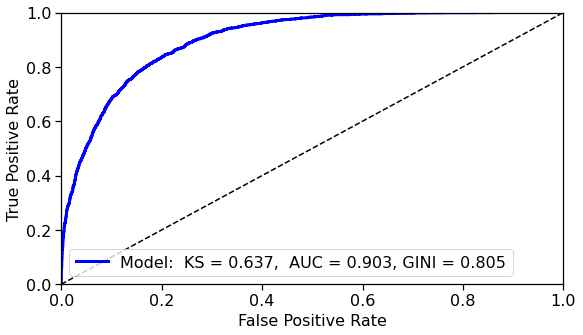

In [557]:
def plot_roc_curve(y, y_pred, gini, ks):
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = (15, 8)

    plt.plot(fpr, tpr, 'b', lw=3, 
             label='%s KS = %0.3f,  AUC = %0.3f, GINI = %0.3f' 
             % ('Model: ',ks, roc_auc, gini))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim([0.0, 1.0], )
    plt.xlabel('False Positive Rate', size=16)
    plt.ylabel('True Positive Rate', size=16)
    plt.legend(loc=0, fontsize=16)
    plt.show()

fpr, tpr, thresholds = roc_curve(data['Target'], data['Prob'])
roc_auc = auc(fpr, tpr)
gini_ = 2 * roc_auc_score(data.Target.values, data.Prob.values) - 1

ks = stats.ks_2samp(data[data['Target'] == 0]['Prob'], 
                    data[data['Target'] == 1]['Prob']).statistic

print(f'KS = {ks :.3} -- AUC = {roc_auc :.3} -- GINI = {gini_ :.3}')

plot_roc_curve(data.Target.values, data.Prob.values, gini_, ks)

In [558]:
fpr, tpr, thresholds = roc_curve(data.Target.values, data.Prob.values)

precision,recall,pr_thresh = precision_recall_curve(data.Target.values, 
                                                    data.Prob.values)

f1_score = 2*precision*recall/(precision+recall)
f1_score = f1_score[:-1]
precision = precision[:-1]
recall = recall[:-1]
f1_score[np.isnan(f1_score)] = -1.0
bestF1 = np.argmax(f1_score)

print(f'O threshold do melhor F1: >>> {pr_thresh[bestF1] :.3} <<<')
print(f'   F1: {f1_score[bestF1] :.3} -- ', end='')
print(f'Precision: {precision[bestF1] :.3} -- ', end='')
print(f'Recall: {recall[bestF1] :.3}')

O threshold do melhor F1: >>> 0.409 <<<
   F1: 0.692 -- Precision: 0.642 -- Recall: 0.75


In [559]:
opt_idx = np.argmin(np.sqrt(np.square(1.0-tpr) + np.square(fpr)))
opt_threshold = thresholds[opt_idx]
print(f'O threshold do melhor F1: {pr_thresh[bestF1] :.3}')

y_hat_best_thres = (data.Prob.values >= pr_thresh[bestF1]).astype(int)
# y_hat_best_thres = (data.Prob.values >= 0.5).astype(int)

print(f'\nMatriz de confusão no thrs {pr_thresh[bestF1] :.3}:')
confusion_matrix(trues, y_hat_best_thres)

O threshold do melhor F1: 0.409

Matriz de confusão no thrs 0.409:


array([[6431,  986],
       [ 587, 1765]])

O threshold do melhor F1: >>> 0.409 <<<
   F1: 0.692 -- Precision: 0.642 -- Recall: 0.75


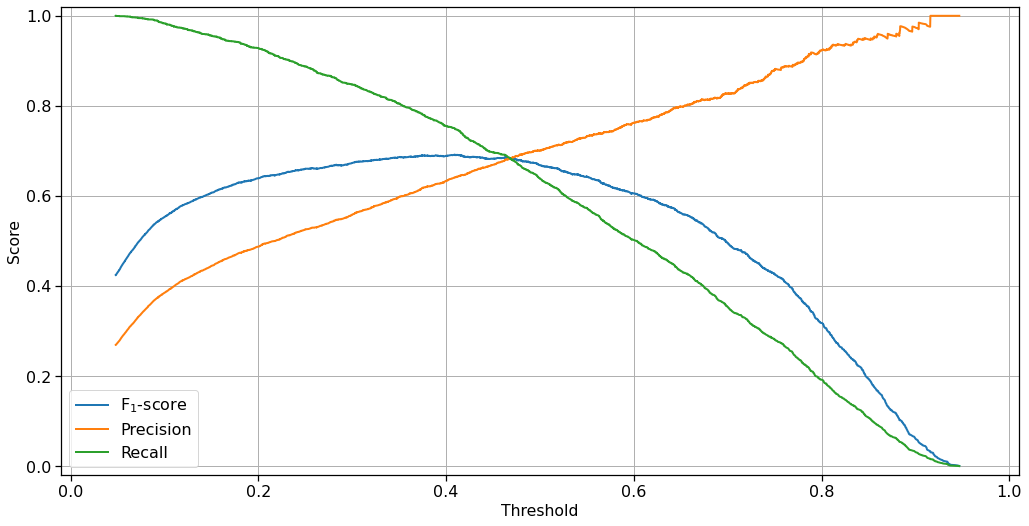

In [560]:
plt.rcParams.update({'font.size': 16})
plt.plot(pr_thresh,f1_score, lw=2)
plt.plot(pr_thresh,precision,  lw=2)
plt.plot(pr_thresh,recall, lw=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.xticks(fontsize=16)
plt.xlim(-0.01, 1.01)
plt.ylim(-0.02, 1.02)
plt.yticks(fontsize=16)
plt.grid()
plt.legend(['F$_1$-score', 'Precision', 'Recall'],prop={'size': 16})
plt.tight_layout(2)
plt.savefig('precision-recall-thres', bbox_inches='tight')
print(f'O threshold do melhor F1: >>> {pr_thresh[bestF1] :.3} <<<')
print(f'   F1: {f1_score[bestF1] :.3} -- ', end='')
print(f'Precision: {precision[bestF1] :.3} -- ', end='')
print(f'Recall: {recall[bestF1] :.3}')

Negados: 2352 Aprovados: 7417


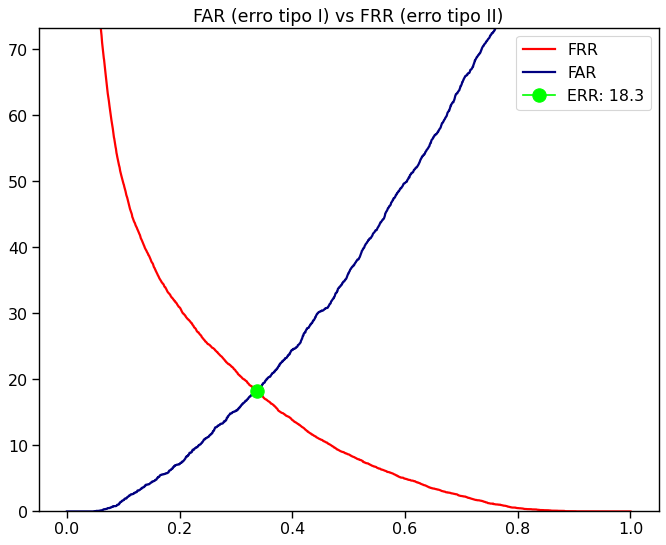

0.337168584292146

In [561]:
_,Err_point = far_vs_frr(data.Target.values, data.Prob.values, steps=2000, fig=True)
Err_point

In [562]:
y_err = (data.Prob.values >= Err_point).astype(int)

print(f'\nMatriz de confusão no ponto do ERR {Err_point :.3}:')
confusion_matrix(trues, y_err)


Matriz de confusão no ponto do ERR 0.337:


array([[6068, 1349],
       [ 433, 1919]])

In [563]:
y_50 = (data.Prob.values >= 0.5).astype(int)

print(f'\nMatriz de confusão no threshold {0.50}:')
confusion_matrix(trues, y_50)


Matriz de confusão no threshold 0.5:


array([[6777,  640],
       [ 850, 1502]])

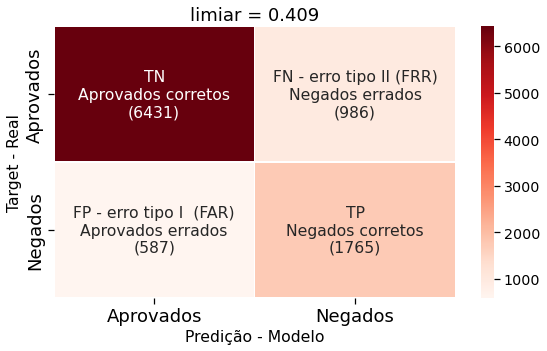

In [564]:
plt.rcParams['figure.figsize'] = (9, 5)

sns.set_context("notebook", font_scale=1.3)

confusao = confusion_matrix(trues, y_hat_best_thres)
group_names = ['TN\nAprovados corretos',
               'FN - erro tipo II (FRR)\nNegados errados', 
               'FP - erro tipo I  (FAR)\nAprovados errados',
               'TP\nNegados corretos']

group_counts = ['({0:0.0f})'.format(value) for value in
                confusao.flatten()]

group_percentages = ['{0:.1%}'.format(value) for value in
                     confusao.flatten()/np.sum(confusao)]

labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

cmap = 'Reds'#'binary'#'PuRd'#'jet'#'YlOrRd'#

ax = sns.heatmap(confusao, annot=labels, fmt='', square=False,
                 cmap=cmap, cbar=True, linewidths=0.7,
                )

ax.set_ylabel('Target - Real')
ax.set_xlabel('Predição - Modelo')
ax.set_xticklabels(['Aprovados','Negados'], va='center', 
                   rotation = 0, position=(0,-0.03), 
                   fontsize=18)
ax.set_yticklabels(['Aprovados','Negados'], 
                   va='center', rotation = 90, position=(0,0.28),
                   fontsize=18)
ax.set_title(f'limiar = {pr_thresh[bestF1] :.3}', fontsize=18)

#######
# Save
#######
plt.savefig('confusao.png', bbox_inches='tight')
plt.show()

# Calibração


In [565]:
def probs_trues_preds(model, dloader, device=device, calibration_method=None, **kwargs):
    
    model.eval()
    
    logits, trues, preds = [],[], []
    for x_cont, x_cat, y in dloader:
        with torch.no_grad():
            y_pred = model(x_cont.to(device), x_cat.to(device))

        if calibration_method:
            y_pred = calibration_method(y_pred, kwargs)

        logits.extend(y_pred.to('cpu').detach().numpy().tolist())
        trues.extend(y.to('cpu').numpy().tolist())
        preds += y_pred.argmax(-1).cpu().numpy().tolist()
    
    prob  = F.softmax(torch.tensor(logits), dim=1).detach().numpy()
    probs = prob[:,1]
    probs = np.array(probs)
    
    trues = np.array(trues)
    preds = np.array(preds)
    return probs, trues, preds

# =============================
probs, trues, preds = probs_trues_preds(model, dataloaders['test'],device)
print(probs.shape, trues.shape, preds.shape)

(9769,) (9769,) (9769,)


In [566]:
def calc_bins(trues_, probs_, K=10):
    # Assign each prediction to a bin
    num_bins = K
    bins = np.linspace(0.1, 1, num_bins)
    binned = np.digitize(probs_, bins)

    # Save the accuracy, confidence and size of each bin
    bin_accs = np.zeros(num_bins)
    bin_confs = np.zeros(num_bins)
    bin_sizes = np.zeros(num_bins)

    for bin in range(num_bins):
        bin_sizes[bin] = len(probs_[binned == bin])
        if bin_sizes[bin] > 0:
            bin_accs[bin] = (trues_[binned==bin]).sum() / bin_sizes[bin]
            bin_confs[bin] = (probs_[binned==bin]).sum() / bin_sizes[bin]

    return bins, binned, bin_accs, bin_confs, bin_sizes

# ============================
bins, binned, bin_accs, bin_confs, bin_sizes = calc_bins(trues, probs, K=2)

# Visualizations and metrics

The Reliability Diagram as figured below intuitively show the relation between expected sample accuracy per bin and confidence.

$acc(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} \mathbf{1}(\hat{y}_i = y_i)$

$conf(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} \hat{p}_i$

For the figure I chose $M=10$, describing the number of seperate bins where the predictions are put in their respective bin based on their magnitude ($Bin 1 = [0.0, 0.1), Bin 2 = [0.1, 0.2), ...)$).

For a perfectly calibrated model is defined as $P(\hat{Y} = Y | \hat{P} = p) = p, \forall p \in [0, 1]$. For Example: Given 100 predictions, each with confidence of 0.8, we expect 80 to be correctly classified. Bars under the identity line show underconfident behavior while bars above it signal overconfidence.


The Expected Calibration Error (ECE) is taking the weighted average of the bins' accuracy/cofidence differences.

$ECE = \sum_{m=1}^{M} \frac{|B_m|}{n} |acc(B_m) + conf(B_m)|$

The Maximum Calibration Error (MCE) focuses more on high risk applications where the maximum accuracy/confidence difference is more important than just the average.

$MCE = \max_m |acc(B_m) + conf(B_m)|$

In [567]:
def get_metrics(trues_, probs_, K=2):
  ECE = 0
  MCE = 0
  bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(trues_, probs_, K)

  for i in range(len(bins)):
    abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
    ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
    MCE = max(MCE, abs_conf_dif)

  return ECE, MCE

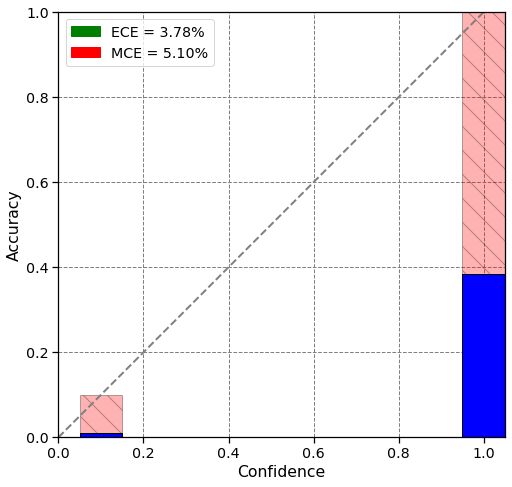

<Figure size 648x360 with 0 Axes>

In [568]:
import matplotlib.patches as mpatches

def draw_reliability_graph(trues_, probs_, K=10):
  ECE, MCE = get_metrics(trues_, probs_, K)
  bins, _, bin_accs, _, _ = calc_bins(trues_, probs_, K)

  fig = plt.figure(figsize=(8, 8))
  ax = fig.gca()

  # x/y limits
  ax.set_xlim(0, 1.05)
  ax.set_ylim(0, 1)

  # x/y labels
  plt.xlabel('Confidence')
  plt.ylabel('Accuracy')

  # Create grid
  ax.set_axisbelow(True) 
  ax.grid(color='gray', linestyle='dashed')

  # Error bars
  plt.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

  # Draw bars and identity line
  plt.bar(bins, bin_accs, width=0.1, alpha=1, edgecolor='black', color='b')
  plt.plot([0,1],[0,1], '--', color='gray', linewidth=2)

  # Equally spaced axes
  plt.gca().set_aspect('equal', adjustable='box')

  # ECE and MCE legend
  ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ECE*100))
  MCE_patch = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(MCE*100))
  plt.legend(handles=[ECE_patch, MCE_patch])

  plt.show()
  
  plt.savefig('calibrated_network.png', bbox_inches='tight')

# ===========================
draw_reliability_graph(trues, probs, K=2)

In [569]:
def T_scaling(logits, args):
  temperature = args.get('temperature', None)
  return torch.div(logits, temperature)

# Temperature Scaling

Temperature Scaling is a parametric calibration approach on the validation set using the Negative-Log-Likelihood (NLL) los. It learns a single parameter $T$ for all classes to update the confidences to $\hat{q}_i = max_k  \sigma_{SM}(z_i/T)^{(k)}$



More sample code can be found in [this](https://github.com/gpleiss/temperature_scaling) awesome GitHub repository by "gpleis".

Final T_scaling factor: 0.70


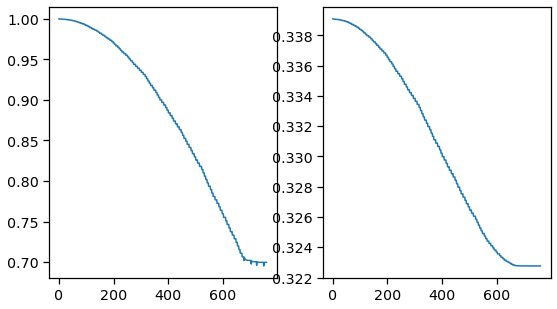

In [570]:
def eval_with_calibration(model, dloader, device, criterion, optimizer, args, temperature):
    model.eval()
    logits, trues, temps, losses = [],[],[],[]
    for x_cont, x_cat, y in dloader:
        with torch.no_grad():
            y_pred = model(x_cont.to(device), x_cat.to(device))
        
        logits.append(y_pred)
        trues.append(y)

    # Create tensors
    logits = torch.cat(logits).to(device)
    trues = torch.cat(trues).to(device)

    def _eval():
        loss = criterion(T_scaling(logits, args), trues)
        loss.backward()
        temps.append(temperature.item())
        losses.append(loss)
        
        return loss


    optimizer.step(_eval)

    print(f'Final T_scaling factor: {temperature.item():.2f}')

    plt.subplot(121)
    plt.plot(list(range(len(temps))), temps)

    plt.subplot(122)
    plt.plot(list(range(len(losses))), losses)
    plt.show() 

# ======================================

criterion = torch.nn.CrossEntropyLoss()
temperature = torch.nn.Parameter(torch.ones(1).to(device))
optimizer = torch.optim.LBFGS([temperature], lr=1e-4, max_iter=100_000, line_search_fn='strong_wolfe')
args= {'temperature': temperature}

eval_with_calibration(
    model, 
    dataloaders['train'], 
    device, 
    criterion, 
    optimizer, 
    args, 
    temperature
    )

In [571]:
torch.tensor(1.2, requires_grad=True).to(device)

tensor(1.2000, device='cuda:0', grad_fn=<CopyBackwards>)

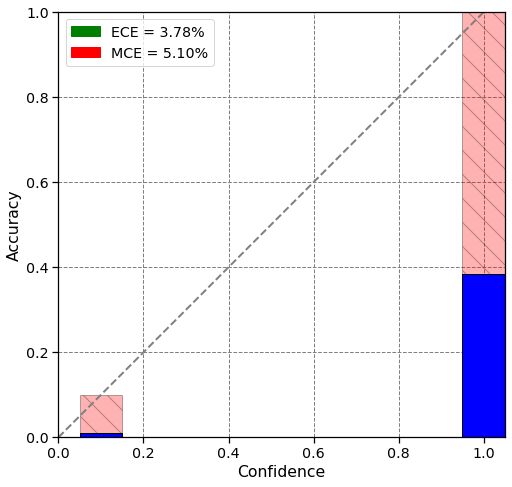

<Figure size 648x360 with 0 Axes>

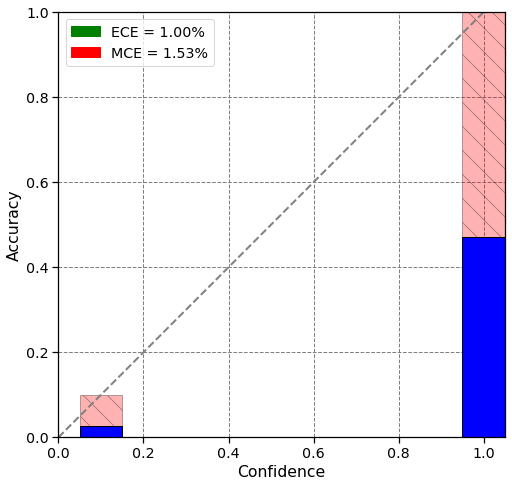

<Figure size 648x360 with 0 Axes>

In [572]:
probs_original, trues_o, preds_original = probs_trues_preds(model, dataloaders['test'], device=device)
draw_reliability_graph(trues_o, probs_original, K=2)

probs_calibrated, trues_c, preds_calibrated = probs_trues_preds(model, dataloaders['test'], device=device, 
                                                          calibration_method=T_scaling,       
                                                          temperature=temperature)
draw_reliability_graph(trues_c, probs_calibrated, K=2)

Negados: 2352 Aprovados: 7417


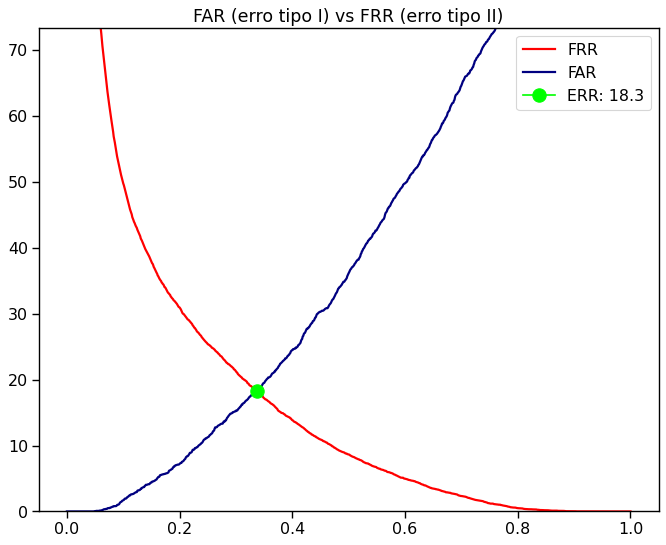

(18.320163780761057, 0.33733733733733734)

In [573]:
far_vs_frr(trues_o, probs_original, fig=True)

Negados: 2352 Aprovados: 7417


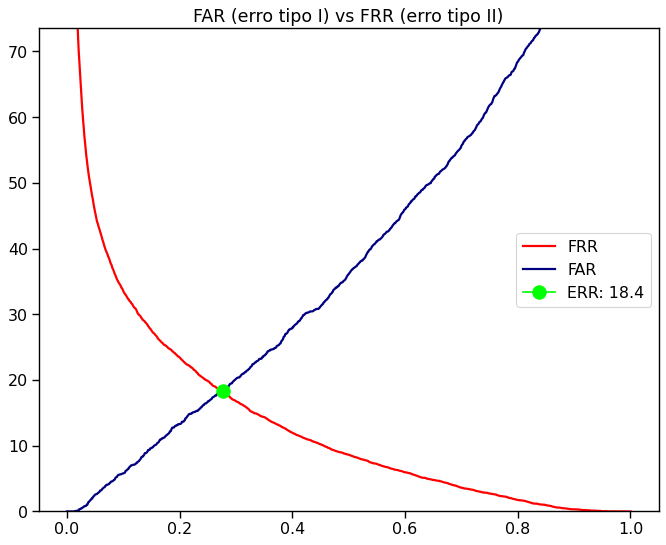

(18.383939290965138, 0.27627627627627627)

In [574]:
far_vs_frr(trues_c, probs_calibrated, fig=True)

In [575]:
probs_original[:10]

array([0.5117969 , 0.67214763, 0.08824917, 0.03984926, 0.46283212,
       0.47427636, 0.1716361 , 0.07693821, 0.05789953, 0.04677993],
      dtype=float32)

In [576]:
probs_calibrated[:10]

array([0.5168561 , 0.73613846, 0.03431321, 0.01048287, 0.44698417,
       0.46327132, 0.09538738, 0.02789675, 0.01822763, 0.0132822 ],
      dtype=float32)

In [577]:
from sklearn.metrics import f1_score
f1_score(probs_original.round(), trues_o), f1_score(trues_c, probs_calibrated.round())

(0.6684468179795282, 0.6684468179795282)

# FIM
